In [279]:
# Load libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler

# Load dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Transform data into valid input to the nn-model. 
le = LabelEncoder()
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(train['Text'])
le.fit(train['Category'])
x_train = tfidf_vectorizer.transform(train['Text'])
y_train = le.transform(train['Category'])
#print(x_train.shape[0])
#print(y_train.shape[0])

x_test = tfidf_vectorizer.transform(test['Text'])
y_test = le.transform(test['Category'])
#print(x_test.shape[0])
#print(y_test.shape[0])

scaler = MaxAbsScaler()
scaler.fit(x_train)

#Hide warnings if you want
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [280]:
def k_fold_data(train, k=5):
        n = len(train)
        fold_size = n // k
        folds = []

        for i in range(k):
            start = i * fold_size
            end = (i + 1) * fold_size if i < k - 1 else n  # handle last fold

            val_set = train.iloc[start:end]
            train_set = pd.concat([train.iloc[:start], train.iloc[end:]])

            folds.append((train_set, val_set))
        
        return folds

five_fold = k_fold_data(train, 5)




In [281]:
from collections import Counter
import numpy as np
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score #Some imports that are useful in runnning NN. 

In [282]:
def nn(x_train, y_train, unit_size): #This returns a model for which you can predict upon input of testing datas.
    x = scaler.transform(x_train)
    y = y_train
    clf = MLPClassifier(hidden_layer_sizes=(unit_size,), activation='relu', solver='adam', max_iter=1, random_state=1, warm_start=True)
    clf.fit(x, y_train) #initialise weight here
    rng = np.random.RandomState(1)
    clf.coefs_[0] = rng.uniform(0, 0.1, size=clf.coefs_[0].shape) #deliberately initialise weight again from 0 to 0.1
    clf.max_iter = 100
    clf.fit(x, y)
    
    return clf

def average_entropy_train_loss(y_pred, y_true):
    n = len(y_true)
    loss = 0
    for i in range(n):
        if y_true[i] == 0:
            loss += -np.log(y_pred[i][0])
        else:
            loss += -np.log(y_pred[i][1])
    
    return loss/n

The two lines being hashed above corresponds to initialising the weight uniformally in range[0, 0.1]. But doing this would make the the model predict everything to 0, not sure why. 

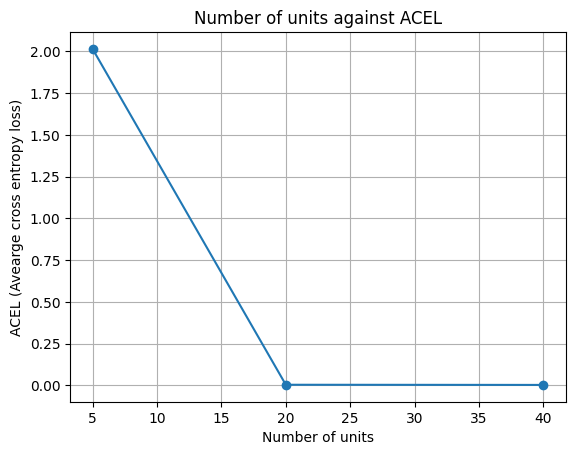

Prediction accuracy:  0.4953271028037383 1.0 1.0


In [283]:
clf5 = nn(x_train, y_train, 5)
clf20 = nn(x_train, y_train, 20)
clf40 = nn(x_train, y_train, 40)

input = scaler.transform(x_train)
pred5 = clf5.predict_proba(input)
pred20 = clf20.predict_proba(input)
pred40 = clf40.predict_proba(input)

number_of_units = [5, 20, 40]
ACELs = [average_entropy_train_loss(pred5, y_train), average_entropy_train_loss(pred20, y_train), average_entropy_train_loss(pred40, y_train)]

plt.plot(number_of_units, ACELs, marker='o')  # 'marker' adds dots at each point
plt.xlabel('Number of units')
plt.ylabel('ACEL (Avearge cross entropy loss)')
plt.title('Number of units against ACEL')
plt.grid(True)
plt.show()

pred5 = clf5.predict(input)
pred20 = clf20.predict(input)
pred40 = clf40.predict(input)

print("Prediction accuracy: ", accuracy_score(y_train, pred5), accuracy_score(y_train, pred20), accuracy_score(y_train, pred40))



All above cooresponds to question 2d, all below are for question 3 of nn

In [284]:
def mportion_nn(x_train, y_train, unit_size, m): #This returns a model for which you can predict upon input of testing datas.
    n = int(x_train.shape[0] * m)
    x_train = x_train[:n]
    y_train = y_train[:n]
    scaler = MaxAbsScaler()
    scaler.fit(x_train)
    x = scaler.transform(x_train)
    y = y_train
    clf = MLPClassifier(hidden_layer_sizes=(unit_size,), activation='relu', solver='adam', max_iter=1, random_state=1, warm_start=True)
    clf.fit(x, y_train) #initialise weight here
    rng = np.random.RandomState(1)
    clf.coefs_[0] = rng.uniform(0, 0.1, size=clf.coefs_[0].shape) #deliberately initialise weight again from 0 to 0.1
    clf.max_iter=100
    clf.fit(x, y)
    
    return clf, scaler

In [285]:
#Assume a unit of 20, we can compute the train_accuracy upon diffeernt size of traing set:

clf10, scaler10 = mportion_nn(x_train, y_train, 20, 0.1)
clf30, scaler30 = mportion_nn(x_train, y_train, 20, 0.3)
clf50, scaler50 = mportion_nn(x_train, y_train, 20, 0.5)
clf70, scaler70 = mportion_nn(x_train, y_train, 20, 0.7)
clf90, scaler90 = mportion_nn(x_train, y_train, 20, 0.9)

input10train, input10test = scaler10.transform(x_train), scaler10.transform(x_test)
print("10 percent f1(train):", f1_score(y_train, clf10.predict(input10train)), "f1(test):", f1_score(y_test, clf10.predict(input10test)))
input30train, input30test = scaler30.transform(x_train), scaler30.transform(x_test)
print("30 percent f1(train):", f1_score(y_train, clf30.predict(input30train)), "f1(test):", f1_score(y_test, clf30.predict(input30test)))
input50train, input50test = scaler50.transform(x_train), scaler50.transform(x_test)
print("50 percent f1(train):", f1_score(y_train, clf50.predict(input50train)), "f1(test):", f1_score(y_test, clf50.predict(input50test)))
input70train, input70test = scaler70.transform(x_train), scaler70.transform(x_test)
print("70 percent f1(train):", f1_score(y_train, clf70.predict(input70train)), "f1(test):", f1_score(y_test, clf70.predict(input70test)))
input90train, input90test = scaler90.transform(x_train), scaler90.transform(x_test)
print("90 percent f1(train):", f1_score(y_train, clf90.predict(input90train)), "f1(test):", f1_score(y_test, clf90.predict(input90test)))



10 percent f1(train): 0.7783783783783784 f1(test): 0.743801652892562
30 percent f1(train): 0.9344978165938864 f1(test): 0.88
50 percent f1(train): 0.9684684684684685 f1(test): 0.946236559139785
70 percent f1(train): 0.9885057471264368 f1(test): 0.9574468085106383
90 percent f1(train): 1.0 f1(test): 0.9782608695652174


In [286]:
from sklearn.model_selection import cross_val_score #Why not using this? Because the assignment specifies that the initial weight has to be between [0, 0.1]

def cross_validate(folds, unit_size, activation = 'relu', initialise_weight = True):
    accuracy = 0
    n = len(folds)
    
    for i in range(n):
        tfidf_vectorizer = TfidfVectorizer()
        scaler = MaxAbsScaler()
        tfidf_vectorizer.fit(folds[i][0]['Text'])
        x_train = tfidf_vectorizer.transform(folds[i][0]['Text'])
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        y_train = le.transform(folds[i][0]['Category'])
        x_test = tfidf_vectorizer.transform(folds[i][1]['Text'])
        x_test = scaler.transform(x_test)
        y_test = le.transform(folds[i][1]['Category'])
        
        clf = MLPClassifier(hidden_layer_sizes=(unit_size,), activation=activation, solver='adam', max_iter=1, random_state=1, warm_start=True)
        clf.fit(x_train, y_train) #initialise weight here
        if initialise_weight:
            rng = np.random.RandomState(1)
            clf.coefs_[0] = rng.uniform(0, 0.1, size=clf.coefs_[0].shape) #deliberately initialise weight again from 0 to 0.1, which is what cross_val_score() can't do
        clf.max_iter=100
        clf.fit(x_train, y_train)

        y_pred = clf.predict(x_test)
        accuracy += accuracy_score(y_test, y_pred)
    
    return accuracy/n

In [287]:
print("5 units: (logistic)", cross_validate(five_fold, 5, 'logistic', True))
print("20 units: (logistic)", cross_validate(five_fold, 20, 'logistic', True))
print("40 units: (logistic)", cross_validate(five_fold, 40, 'logistic', True))
print("5 units: (relu)", cross_validate(five_fold, 5, 'relu', True))
print("20 units: (relu)", cross_validate(five_fold, 20, 'relu', True))
print("40 units: (relu)", cross_validate(five_fold, 40, 'relu', True))
print("5 units: (logistic)(default weight)", cross_validate(five_fold, 5, 'logistic', False))
print("20 units: (logistic)(default weight)", cross_validate(five_fold, 20, 'logistic', False))
print("40 units: (logistic)(default weight)", cross_validate(five_fold, 40, 'logistic', False))
print("5 units: (relu)(default weight)", cross_validate(five_fold, 5, 'relu', False))
print("20 units: (relu)(default weight)", cross_validate(five_fold, 20, 'relu', False))
print("40 units: (relu)(default weight)", cross_validate(five_fold, 40, 'relu', False))

5 units: (logistic) 0.9577272727272726
20 units: (logistic) 0.7610962566844919
40 units: (logistic) 0.9600802139037432
5 units: (relu) 0.962433155080214
20 units: (relu) 0.8575668449197862
40 units: (relu) 0.9483155080213903
5 units: (logistic)(default weight) 0.9624331550802138
20 units: (logistic)(default weight) 0.9600802139037432
40 units: (logistic)(default weight) 0.9553743315508021
5 units: (relu)(default weight) 0.967139037433155
20 units: (relu)(default weight) 0.9694919786096257
40 units: (relu)(default weight) 0.9718449197860963


It seems like NN performs the best with unit number of 5, which achive a training accuracy of 96.2%, and the worst with unit number of 20, only 85%. However, Scikit Learn's weight initialisation seems to perform better overall, all of which achieve around 97% of accuracy, regardless of the number of units in the hidden layer. The use of activation function doesn't seem to have huge effect on the prediction outcome with the current implementation. 

As the size of the training set increases, the F1 score on the testing dataset is increasing. This tells us that the testing data could be in high similarity to the training data. 